In [80]:
# python warning off
import warnings
warnings.filterwarnings('ignore')

# tensorflow warning off
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import PIL

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16168061355712894116
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17294198353390635585
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4109062148495230933
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12701427230716716843
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [81]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=42, test_size=0.2
)
X_test, X_adv_test, y_test, y_adv_test = train_test_split(
    X_test, y_test, random_state=42, test_size=0.1 
)

In [83]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape, X_adv_test.shape, y_adv_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (9000, 32, 32, 3),
 (9000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (1000, 32, 32, 3),
 (1000, 1))

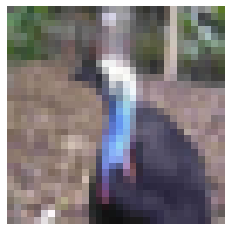

In [84]:
plt.imshow(X_train[1])
plt.axis('off')
plt.show()

In [85]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [86]:
type(y_train[0])

numpy.ndarray

In [87]:
class_names[y_train[1][0]]

'bird'

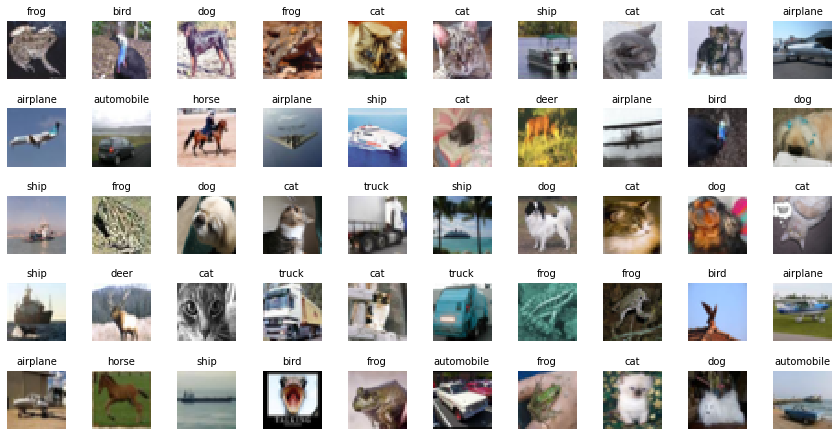

In [88]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [89]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 32*32*3))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], 32*32*3))
X_valid = scaler.transform(X_valid.reshape(X_valid.shape[0], 32*32*3))
X_adv_test = scaler.transform(X_adv_test.reshape(X_adv_test.shape[0], 32*32*3))
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_valid = X_valid.reshape(X_valid.shape[0], 32, 32, 3)
X_adv_test = X_adv_test.reshape(X_adv_test.shape[0], 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


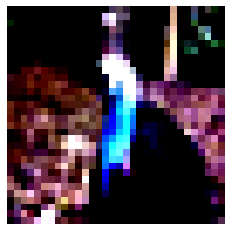

In [90]:
plt.imshow(X_train[1])
plt.axis('off')
plt.show()

In [91]:
model = keras.models.Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# happen a problem when not using Dropout.

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)        

In [92]:
%%time
MODEL_DIR_PATH = 'cnn_model/'
if not os.path.exists(MODEL_DIR_PATH):
    os.mkdir(MODEL_DIR_PATH)
model_path = MODEL_DIR_PATH + "{epoch:03d}-{accuracy:.4f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='accuracy', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
result = model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint, early_stopping])

Epoch 1/100
79/79 [==============================] - 8s 97ms/step - loss: 1.9204 - accuracy: 0.2725 - val_loss: 1.5901 - val_accuracy: 0.4092
Epoch 2/100
79/79 [==============================] - 8s 96ms/step - loss: 1.4814 - accuracy: 0.4426 - val_loss: 1.3358 - val_accuracy: 0.5065
Epoch 3/100
79/79 [==============================] - 8s 96ms/step - loss: 1.2675 - accuracy: 0.5368 - val_loss: 1.1101 - val_accuracy: 0.5926
Epoch 4/100
79/79 [==============================] - 8s 97ms/step - loss: 1.0682 - accuracy: 0.6145 - val_loss: 0.9294 - val_accuracy: 0.6651
Epoch 5/100
79/79 [==============================] - 8s 98ms/step - loss: 0.9288 - accuracy: 0.6714 - val_loss: 0.8267 - val_accuracy: 0.7020
Epoch 6/100
79/79 [==============================] - 8s 99ms/step - loss: 0.8368 - accuracy: 0.7062 - val_loss: 0.7626 - val_accuracy: 0.7325
Epoch 7/100
79/79 [==============================] - 8s 98ms/step - loss: 0.7496 - accuracy: 0.7391 - val_loss: 0.7313 - val_accuracy: 0.7463
Epoch 

In [93]:
result.params

{'epochs': 100, 'steps': 79, 'verbose': 1}

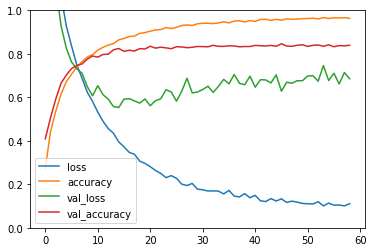

In [104]:
pd.DataFrame(result.history).plot()
plt.gca().set_ylim(0,1)
plt.show()

In [95]:
model.evaluate(X_test, y_test)

282/282 [==============================] - 1s 4ms/step - loss: 0.6805 - accuracy: 0.8419


[0.6804646849632263, 0.8418889045715332]

In [96]:
predictions = model.predict(X_adv_test)

array([7.8782305e-09, 1.7369931e-13, 1.0000000e+00, 2.5504185e-09,
       8.2007828e-10, 2.3295080e-08, 1.3474292e-08, 6.6224339e-11,
       1.9232073e-10, 2.3980335e-15], dtype=float32)

In [100]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


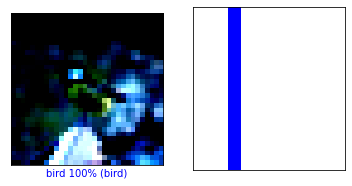

In [101]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_adv_test, X_adv_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_adv_test)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


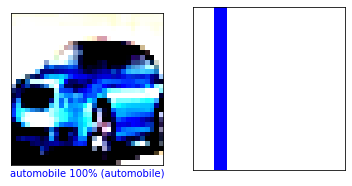

In [106]:
i = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_adv_test, X_adv_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_adv_test)
plt.show()

In [102]:
# 분류기 성능 올리기
# uniform noise, image back-prop, FGSM, autoencoder, randomization layers 구현하기
# transfer learning으로 모델 옮기기